In [69]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.io.shapereader as shapereader
import xarray as XR
import metpy
from metpy.units import units
import metpy.calc as mpcalc
#from mpl_toolkits.basemap import cm
import sys # to get argv
import os
import warnings
warnings.filterwarnings('ignore')

In [70]:
#---読み込むデータの設定-------
#argvs = sys.argv
#nc =  argvs[1] 
#nc = '../data/lfm/4v-lfm_lfmkyushu_2021-07-09_15utc.nc'
nc = '../data/lfm/4p-lfm_lfmkyushu_2021-07-09_15utc.nc'
#lev = 950 # 読み込む気圧面(hPa) # for 4p-LFM
it = 0    # 時刻スライス(0:解析値, >=1:予測値)
xmin, xmax, ymin, ymax = 128.0, 133.0, 30.0, 35.0 # 可視化領域の設定
#xmin, xmax, ymin, ymax = 129.0, 132.0, 31.0, 34.0 # 可視化領域の設定

In [71]:
#--- データの読み込み------------------
#xr  = XR.open_dataset(nc)
xr  = XR.open_dataset(nc).sel(LON=slice(xmin,xmax)).sel(LAT=slice(ymin,ymax))
rh = xr["RH"]
u  = xr["U"]
v  = xr["V"]
T  = xr["T"]

P    = xr["P"]   * 0.01    # pressure[pascal=>hPa]
SLP  = xr["SLP"] * 0.01 # sea level pressure[pascal=>hPa]
#xr
#SLP.isel(TIME=0).plot()
#P.isel(TIME=0).plot()

In [72]:
#---水蒸気混合比の計算(Tとpから計算)-------------------
rh0 = rh.isel(TIME=it)#.sel(LEV=lev)
T0  = T.isel(TIME=it)#.sel(LEV=lev)
P0  = P.isel(TIME=it) # for 4v data

In [73]:
#tp  = units.Quantity(lev, "hPa") # for 4v data
tp  = P0 * units.hPa # for 4p data

In [74]:
#qvs = mpcalc.saturation_mixing_ratio(P0, T0) * 1000  # for 4p data
qvs = mpcalc.saturation_mixing_ratio(tp, T0) * 1000 # for 4v data
qv = qvs * rh0 / 100.0 
#qv.plot()

In [75]:
#---図の設定-------------
proj = ccrs.PlateCarree() # 正距円筒図法
#proj_l = ccrs.LambertConformal(central_longitude=130.5, central_latitude=32.5) # ランベルト正角円錐図法
#fs = 16
#plt.rcParams["font.size"]   = fs
#plt.rcParams["font.family"] = "fontname"


fig_4p-lmf_qv-U.png


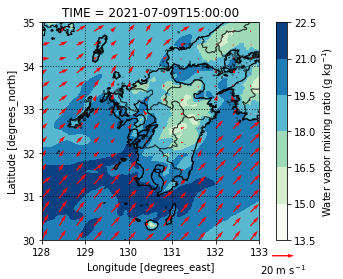

In [76]:
#---プロット領域の作成-----------
fig = plt.figure()
#fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(1, 1, 1, projection=proj)
#ax = fig.add_subplot(1, 1, 1, projection=proj_l)

#---シェードを描く-------------------
#vmin = 50; vmax = 75 
cmap = "GnBu"
#cmap = cm.GMT_drywet
#pw1.plot(vmin=vmin, vmax=vmax, cmap=cmap, levels=6)
#print(qv)
qv.plot.contourf(ax=ax,transform=proj, cmap=cmap,cbar_kwargs={'label':'Water vapor mixing ratio (g kg$^{-1}$)'})#,levels=clevels,cmap='rainbow'
#print(rh0)

#---緯度線、経度線を描く----------
dlon, dlat = 1, 1
#xticks = np.arange(128, 133, dlon)
#yticks = np.arange( 30,  35, dlat)
#dlon, dlat = 10, 10
xticks = np.arange(-180, 180, dlon)
yticks = np.arange(-90, 90.1, dlat)

#ax.coastlines(resolution='10m') #日本以外の地図が必要・海岸線を太い線にする場合はコメントを外す
ax.set_xticks(xticks,crs=proj)
ax.set_yticks(yticks,crs=proj)

dl = 0.001
ax.set_extent([xmin-dl, xmax+dl, ymin-dl, ymax+dl], crs=proj)  # 領域の限定

#-----経度、緯度線を描く-----
#gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
#gl = ax.gridlines(crs=proj, draw_labels=True,
gl = ax.gridlines(crs=proj, draw_labels=False,
                  linewidth=1, linestyle=':', color='k', alpha=0.8)
gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator(xticks)  # 経度線
gl.ylocator = mticker.FixedLocator(yticks)  # 緯度線

#---陸・海・川・湖を塗り分けて描く----------------
#!ax.add_feature(cfeature.LAND)  # 可視化する領域を狭く5度×5度くらいにすると、
#!ax.add_feature(cfeature.OCEAN) # LANDやOCEANを描くと合わせて20秒近くかかってしまう...
ax.add_feature(cfeature.COASTLINE, linewidth=1)
#ax.add_feature(cfeature.LAKES)
#!#ax.add_feature(cfeature.LAKES, alpha=0.5)
#ax.add_feature(cfeature.RIVERS)

#---県境・市町村境界を描く-----
#  * 以下のWebページを参考にDLしたシェープファイル利用:
#    * Pythonで世界地図-26(各国の県境・市町村境を表示): https://qiita.com/ty21ky/items/193e316370a8c7122b3c 
#fname = 'gadm36_JPN_shp/gadm36_JPN_0.shp' #国境線のみ
fname1 = 'gadm36_JPN_shp/gadm36_JPN_1.shp' #県境
fname2 = 'gadm36_JPN_shp/gadm36_JPN_2.shp' #市町村境

adm1_shapes = list(shapereader.Reader(fname1).geometries())
adm2_shapes = list(shapereader.Reader(fname2).geometries())
#ax.add_geometries(adm2_shapes, proj, edgecolor='gray', facecolor='cyan',  alpha=0.5) #市町村境
#ax.add_geometries(adm2_shapes, proj, edgecolor='gray',  alpha=0.5) #市町村境
ax.add_geometries(adm1_shapes, proj, edgecolor='black', facecolor='none',alpha=0.5) #県境

#---ベクトルを描く-------------------
#Usub = u.isel(TIME=it).sel(LEV=lev) # for 4v data
#Vsub = v.isel(TIME=it).sel(LEV=lev) # for 4v data
Usub = u.isel(TIME=it) # for 4p data
Vsub = v.isel(TIME=it) # for 4p data

# low-resolution data
# (経度-緯度方向は適当に間引いて読み込む; そうしないと、描いたベクトルがギチギチになるので）
#dx = 8; dy = 8 # for 4v data
dx = 16; dy = 16 # for 4p data

U_lr = Usub[::dy,::dx].values #[::c]は "c毎にデータを取得する"]の意味, ".values"はndarrayへの変換（軸情報を落として単なる数値配列に）
V_lr = Vsub[::dy,::dx].values

# 軸もそれに合わせて間引く
lon_lr = Usub['LON'][::dx].values
lat_lr = Vsub['LAT'][::dy].values

# ベクトル場を描く
Q = ax.quiver(lon_lr,lat_lr,U_lr,V_lr,color='r',transform=proj, width=0.006)
#Q = ax.quiver(lon_lr,lat_lr,U_lr,V_lr,color='darkorange',transform=proj)

# 単位ベクトルを描く
#ax.quiverkey(Q,0.8,0.95,fs,label='20 m s$^{-1}$',labelpos='S',coordinates="figure")
ax.quiverkey(Q,0.8,0.07,16,label='20 m s$^{-1}$',labelpos='S',coordinates="figure")
#------------------------------------

# ファイルへの書き出し
#from pathlib import Path
#exe = Path().resolve().split(".")[0] #.replace("draw", "")
#exe = os.path.basename(__file__).split(".")[0] #.replace("draw", "")
fig_name = "fig_4p-lmf_qv-U.png"
#fig_name = "fig_" + exe + ".png"
print(fig_name)
plt.savefig(fig_name, dpi=300, bbox_inches='tight')
plt.show()
